## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Arthropoda - Steven</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this second notebook, we will preprocess images from the **Arthropoda** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image


In [2]:
#Libraries from Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import image_dataset_from_directory
from keras import optimizers

2025-04-09 13:06:18.028807: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 13:06:18.142862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744200378.235986   67565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744200378.256968   67565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744200378.341595   67565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Arthropoda Phylum.

In [3]:
# Load the DataFrame from the CSV file
arthropoda_train = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_train.csv")
arthropoda_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28260809,1065329,animalia,arthropoda,apidae,arthropoda_apidae/28260809_1065329_eol-full-si...
1,29945328,1077217,animalia,arthropoda,pseudophasmatidae,arthropoda_pseudophasmatidae/29945328_1077217_...
2,14644212,463474,animalia,arthropoda,formicidae,arthropoda_formicidae/14644212_463474_eol-full...


In [4]:
# Load the DataFrame from the CSV file
arthropoda_test = pd.read_csv("/home/sacar/DeepLearning2425/train_test_splits/arthropoda_test.csv")
arthropoda_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,28408206,1065346,animalia,arthropoda,apidae,arthropoda_apidae/28408206_1065346_eol-full-si...
1,28253620,1065348,animalia,arthropoda,apidae,arthropoda_apidae/28253620_1065348_eol-full-si...
2,21847584,1065348,animalia,arthropoda,apidae,arthropoda_apidae/21847584_1065348_eol-full-si...


# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [5]:
#Define some stuff
num_classes = arthropoda_train['family'].nunique() #number of classes = number of families
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)


In [6]:
#Define preprocess and augmentation functions

#Function to preprocess the images
def process_image(file_path, label):
    image = tf.io.read_file(file_path) # Read the image file
    image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
    image = tf.image.resize(image, image_size) # Resize the image to the target size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label


#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)


I0000 00:00:1744200383.427721   67565 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
root_dir = "/home/sacar/DeepLearning2425/rare_species"

#Get the file paths and labels for the training and test set
arthropoda_train['full_path'] = arthropoda_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
arthropoda_test['full_path'] = arthropoda_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

file_paths_train = arthropoda_train['full_path'].tolist()
labels_train = arthropoda_train['family'].tolist()

file_paths_test = arthropoda_test['full_path'].tolist()
labels_test = arthropoda_test['family'].tolist()

#Map the labels to integers
label_names = sorted(set(labels_train)) # Get the unique labels
label_to_index = {name: i for i, name in enumerate(label_names)} # Create a mapping from labels to integers
labels_train = [label_to_index[label] for label in labels_train]
labels_test = [label_to_index[label] for label in labels_test]

print(file_paths_train[:5])
print(labels_train[:5])
print(file_paths_test[:5])
print(labels_test[:5])

['/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28260809_1065329_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_pseudophasmatidae/29945328_1077217_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_formicidae/14644212_463474_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_pseudophasmatidae/29945335_1077217_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_papilionidae/21035374_130548_eol-full-size-copy.jpg']
[0, 13, 5, 13, 10]
['/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28408206_1065346_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/28253620_1065348_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_apidae/21847584_1065348_eol-full-size-copy.jpg', '/home/sacar/DeepLearning2425/rare_species/arthropoda_formicidae/14681521_403723_eol-full-size-copy.jpg', '/home/sacar/DeepLe

In [8]:
#Create the tensorflow datasets

#Load data
data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42) # Shuffle the dataset

#Create train/val
train_size = int(0.8 * len(file_paths_train)) #80% for training, 20% for validation
train = data.take(train_size) # Take the first 80% for training
val = data.skip(train_size) # Skip the first 80% for validation

#Training preprocess pipeline
train = train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
train = train.cache() # Cache the dataset for faster access
train = train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
train = train.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=True, seed=42).batch(8).prefetch(buffer_size=tf.data.AUTOTUNE) #shuffle and batch

#Validation preprocess pipeline
val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE) # Map the function to the dataset
val = val.cache() # Cache the dataset for faster access
val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE) #batch


#Test preprocess pipeline
test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)

In [9]:
for image, label in train.take(3):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

for image, label in test.take(3):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (8, 224, 224, 3)
Label: [0 8 5 5 2 8 0 5]
Image shape: (8, 224, 224, 3)
Label: [4 0 5 5 5 6 0 1]
Image shape: (8, 224, 224, 3)
Label: [ 3  5  3 11  6 10  1  3]
Image shape: (8, 224, 224, 3)
Label: [ 0  0  0  5  9  0 16  5]
Image shape: (8, 224, 224, 3)
Label: [ 5  5  0 16  6  0 11  0]
Image shape: (8, 224, 224, 3)
Label: [ 0  5 13  5  5  8  5  0]


2025-04-09 13:06:28.661183: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-09 13:06:28.764993: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-09 13:06:28.801291: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [11]:
#Create the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


/home/sacar/tf_wsl_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
#Train the model
history = model.fit(train, epochs=200, validation_data=val, verbose=1)

#Save the model
model.save('model2.h5') # Save the model

Epoch 1/200


I0000 00:00:1744200393.410840   67662 service.cc:152] XLA service 0x7f8b9800c280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744200393.410939   67662 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-09 13:06:33.460592: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744200393.746288   67662 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-09 13:06:34.584591: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[8,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0} %bitcast.4789, f32[32,3,3,3]{3,2,1,0} %bitcast.4796, f32[32]{0} %bitcast.5421), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$conv

 4/74 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4557 - loss: 2.4784

I0000 00:00:1744200400.063326   67662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/74 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3060 - loss: 2.4725

2025-04-09 13:06:43.049257: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[5,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,224,224]{3,2,1,0} %bitcast.4789, f32[32,3,3,3]{3,2,1,0} %bitcast.4796, f32[32]{0} %bitcast.5421), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/sacar/tf_wsl_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-09 13:06:43.190796: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially bug

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3060 - loss: 2.4705

2025-04-09 13:06:47.388396: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.12 = (f32[8,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0} %bitcast.555, f32[32,3,3,3]{3,2,1,0} %bitcast.562, f32[32]{0} %bitcast.564), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/sacar/tf_wsl_env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-09 13:06:47.633621: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy 

74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.3060 - loss: 2.4695 - val_accuracy: 0.3041 - val_loss: 2.2200
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3805 - loss: 2.2154 - val_accuracy: 0.4257 - val_loss: 1.9905
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4178 - loss: 2.1097 - val_accuracy: 0.4324 - val_loss: 2.0276
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4344 - loss: 2.0150 - val_accuracy: 0.4122 - val_loss: 1.9682
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4218 - loss: 2.0178 - val_accuracy: 0.4527 - val_loss: 1.7944
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4015 - loss: 1.9855 - val_accuracy: 0.4730 - val_loss: 1.8937
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4096 - loss: 1.9137 - val_accuracy: 0.4730 - val_loss: 1.8058
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.4599 - loss: 1.8052 - val_accuracy: 0.5135 - val

Training history saved to history_run_1_aug_settings_A.csv
Training plot saved to plot_run_1_aug_settings_A.png


<Figure size 640x480 with 0 Axes>

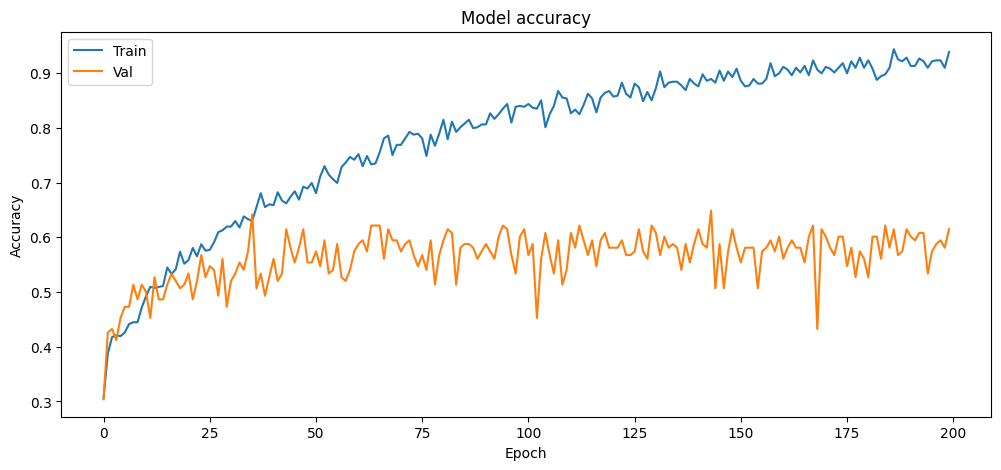

In [14]:
# Save the history object
history_df = pd.DataFrame(history.history)
history_filename = 'history_run_1_aug_settings_A.csv' # Match naming convention
history_df.to_csv(history_filename, index=False)
print(f"Training history saved to {history_filename}")

# Optional: Save a plot of the training history immediately

plot_filename = 'plot_run_1_aug_settings_A.png' # Match naming convention
plt.savefig(plot_filename)
print(f"Training plot saved to {plot_filename}")

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()